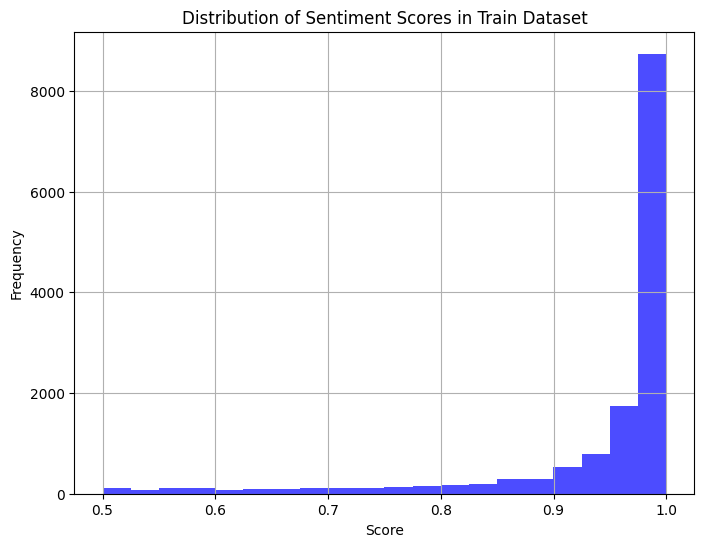

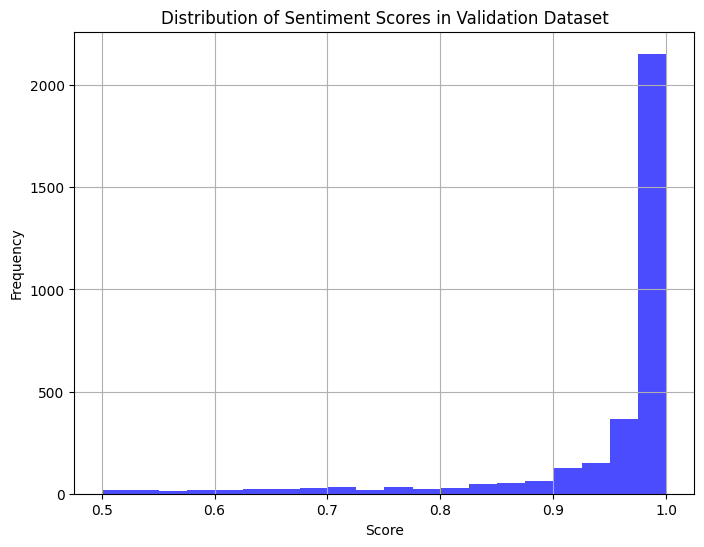

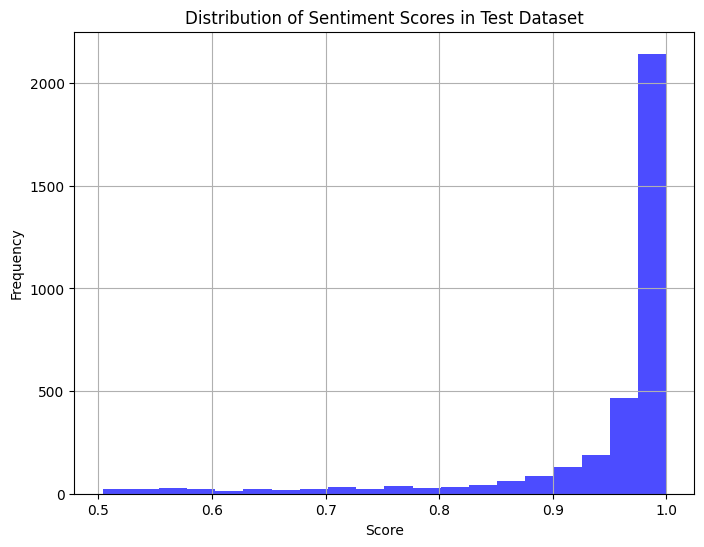

Number of neutral sentences in Train Dataset: 779
Number of neutral sentences in Validation Dataset: 157
Number of neutral sentences in Test Dataset: 176


In [7]:
import matplotlib.pyplot as plt
from datasets import load_from_disk

# Load the dataset from disk
dataset = load_from_disk("../data/conll2003_dataset")

# Plot score distribution for each split
def plot_score_distribution(scores, title):
    plt.figure(figsize=(8, 6))
    plt.hist(scores, bins=20, color='blue', alpha=0.7)
    plt.title(title)
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Plot distributions for train, validation, and test datasets
plot_score_distribution(dataset["train"]["scores"], "Distribution of Sentiment Scores in Train Dataset")
plot_score_distribution(dataset["validation"]["scores"], "Distribution of Sentiment Scores in Validation Dataset")
plot_score_distribution(dataset["test"]["scores"], "Distribution of Sentiment Scores in Test Dataset")

# Count neutral sentences in each split
neutral_count_train = sum(1 for label in dataset["train"]["sentiments"] if label == "NEUTRAL")
neutral_count_validation = sum(1 for label in dataset["validation"]["sentiments"] if label == "NEUTRAL")
neutral_count_test = sum(1 for label in dataset["test"]["sentiments"] if label == "NEUTRAL")

print(f"Number of neutral sentences in Train Dataset: {neutral_count_train}")
print(f"Number of neutral sentences in Validation Dataset: {neutral_count_validation}")
print(f"Number of neutral sentences in Test Dataset: {neutral_count_test}")


In [6]:
low_score_threshold = 0.7
low_score_sentences = [sentence for sentence, score in zip(dataset["train"]["tokens"], dataset["train"]["scores"]) if score < low_score_threshold]

print(f"Number of low-score sentences: {len(low_score_sentences)}")
print("Examples of low-score sentences:", low_score_sentences[:5])


Number of low-score sentences: 3136
Examples of low-score sentences: [['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], ['The', 'European', 'Commission', 'said', 'on', 'Thursday', 'it', 'disagreed', 'with', 'German', 'advice', 'to', 'consumers', 'to', 'shun', 'British', 'lamb', 'until', 'scientists', 'determine', 'whether', 'mad', 'cow', 'disease', 'can', 'be', 'transmitted', 'to', 'sheep', '.'], ['Germany', "'s", 'representative', 'to', 'the', 'European', 'Union', "'s", 'veterinary', 'committee', 'Werner', 'Zwingmann', 'said', 'on', 'Wednesday', 'consumers', 'should', 'buy', 'sheepmeat', 'from', 'countries', 'other', 'than', 'Britain', 'until', 'the', 'scientific', 'advice', 'was', 'clearer', '.'], ['"', 'We', 'do', "n't", 'support', 'any', 'such', 'recommendation', 'because', 'we', 'do', "n't", 'see', 'any', 'grounds', 'for', 'it', ',', '"', 'the', 'Commission', "'s", 'chief', 'spokesman', 'Nikolaus', 'van', 'der', 'Pas', 'told', 'a', 'news', 'briefing', '

In [10]:
!pip install datasets transformers tqdm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [14]:
import os
from datasets import load_from_disk
from transformers import pipeline
from tqdm import tqdm

# Define dataset path
dataset_path = "../data/conll2003_dataset"

# Load the dataset from disk
if os.path.exists(dataset_path):
    print("Loading dataset from disk...")
    dataset = load_from_disk(dataset_path)
else:
    raise FileNotFoundError(f"Dataset not found at {dataset_path}. Please process and save it first.")

# Load the sentiment-analysis pipeline for cardiffnlp/twitter-roberta-base-sentiment
sentiment_analyzer_cardiff = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

# Define a function to analyze sentiments with Cardiff NLP model
# Define a function to analyze sentiments with Cardiff NLP model
def analyze_with_cardiff(sentences):
    sentiments = []
    for sentence in tqdm(sentences, desc="Analyzing Sentiments with Cardiff NLP"):
        result = sentiment_analyzer_cardiff(sentence)[0]  # Analyze one sentence
        label = result["label"]
        score = result["score"]
        
        # Map labels to integers: Negative = 0, Neutral = 1, Positive = 2
        if label == "LABEL_0":
            mapped_label = "NEGATIVE"
        elif label == "LABEL_1":
            mapped_label = "NEUTRAL"
        elif label == "LABEL_2":
            mapped_label = "POSITIVE"
        else:
            # Fallback case (unexpected label)
            print(f"Unexpected label '{label}' encountered. Defaulting to NEUTRAL.")
            mapped_label = 1
        
        sentiments.append({"label": mapped_label, "score": score})
    return sentiments


# Analyze sentiments for train, validation, and test splits
print("Extracting sentences...")
train_sentences = [" ".join(tokens) for tokens in dataset["train"]["tokens"]]
validation_sentences = [" ".join(tokens) for tokens in dataset["validation"]["tokens"]]
test_sentences = [" ".join(tokens) for tokens in dataset["test"]["tokens"]]

print("Analyzing train set...")
train_sentiments_cardiff = analyze_with_cardiff(train_sentences)
print("Analyzing validation set...")
validation_sentiments_cardiff = analyze_with_cardiff(validation_sentences)
print("Analyzing test set...")
test_sentiments_cardiff = analyze_with_cardiff


Loading dataset from disk...


Device set to use cpu


Extracting sentences...
Analyzing train set...


Analyzing Sentiments with Cardiff NLP: 100%|██████████| 14041/14041 [13:02<00:00, 17.93it/s] 


Analyzing validation set...


Analyzing Sentiments with Cardiff NLP: 100%|██████████| 3250/3250 [02:21<00:00, 22.98it/s]

Analyzing test set...


In [15]:
def compare_labels(original_labels, cardiff_labels):
    matches = sum(1 for orig, cardiff in zip(original_labels, cardiff_labels) if orig == cardiff)
    total = len(original_labels)
    accuracy = matches / total * 100
    return accuracy

print("Comparing train set...")
train_accuracy = compare_labels(
    dataset["train"]["sentiments"],
    [result["label"] for result in train_sentiments_cardiff]
)

print("Comparing validation set...")
validation_accuracy = compare_labels(
    dataset["validation"]["sentiments"],
    [result["label"] for result in validation_sentiments_cardiff]
)

print("Comparing test set...")
test_accuracy = compare_labels(
    dataset["test"]["sentiments"],
    [result["label"] for result in test_sentiments_cardiff]
)

# Print results
print(f"Train Accuracy: {train_accuracy:.2f}%")
print(f"Validation Accuracy: {validation_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")

Comparing train set...
Comparing validation set...
Comparing test set...


TypeError: 'function' object is not iterable